## Import Library

In [154]:
import os, errno
import argparse
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from scipy.stats import kurtosis
from scipy.stats.mstats import moment
from scipy import stats
from scipy.stats import ttest_ind, f_oneway

sys.path.append(os.path.join(os.path.curdir, '../../', 'util'))
from load_data_basic import *

# date_time format
date_time_format = '%Y-%m-%dT%H:%M:%S.%f'
date_only_date_time_format = '%Y-%m-%d'

# sleep after work duration thereshold
sleep_after_work_duration_threshold = 12
sleep_after_sleep_duration_threshold = 2

# data folder
main_data_directory = '../../../data/'
recording_timeline_directory = '../../output/recording_timeline'
sleep_timeline_directory = '../../output/sleep_timeline'
individual_timeline_directory = '../../output/individual_timeline'



## Read Basic Information

In [155]:
# Read sleep data for all participant
sleep_data = pd.read_csv(os.path.join('../../output', 'sleep_survey_full.csv'))

# Read participant information
participant_info = getParticipantInfo(main_data_directory)
# participant_info = participant_info.set_index('MitreID')

# Read MGT
MGT = read_MGT(main_data_directory)

# Read Pre-Study info
PreStudyInfo = read_pre_study_info(main_data_directory)

# Read IGTB info
IGTB = read_IGTB(main_data_directory)

# Demographic
Demographic = read_Demographic(main_data_directory)

# Day shift data
day_data = sleep_data.loc[sleep_data['shift_type'] == 1]
day_workday_data = day_data.loc[(day_data['is_sleep_before_work'] == 1) & (day_data['is_sleep_after_work'] == 1)]
day_off_day_data = day_data.loc[(day_data['is_sleep_before_work'] != 1) & (day_data['is_sleep_after_work'] != 1)]
day_transition_day_data = day_data.loc[(day_data['is_sleep_transition_before_work'] == 1) | (day_data['is_sleep_transition_after_work'] == 1)]

# Night shift data
night_data = sleep_data.loc[sleep_data['shift_type'] == 2]
night_workday_data = night_data.loc[(night_data['is_sleep_before_work'] == 1) & (night_data['is_sleep_after_work'] == 1)]
night_off_day_data = night_data.loc[(night_data['is_sleep_before_work'] != 1) & (night_data['is_sleep_after_work'] != 1)]
night_transition_day_data = night_data.loc[(night_data['is_sleep_transition_before_work'] == 1) | (night_data['is_sleep_transition_after_work'] == 1)]

# Data array
data_array = [day_data, night_data, 
              day_workday_data, day_off_day_data, 
              night_workday_data, night_off_day_data]

data_type = ['day-shift all', 'night-shift all',
             'day-shift workday', 'day-shift off day', 
             'night-shift workday', 'night-shift off day']

colunm_type = ['duration_in_seconds', 'SleepEfficiency',
               'SleepMinutesStageDeep', 'SleepMinutesStageLight', 'SleepMinutesStageRem',
               'sleep_heart_rate_mean', 'sleep_heart_rate_std',
               'sleep_heart_rate_percentile_10', 'sleep_heart_rate_percentile_90']

UserInfo = pd.merge(IGTB, PreStudyInfo, left_on='uid', right_on='uid', how='outer')
UserInfo = pd.merge(UserInfo, participant_info, left_on='uid', right_on='MitreID', how='outer')
UserInfo = pd.merge(UserInfo, Demographic, left_on='uid', right_on='uid', how='outer')
UserInfo = UserInfo.loc[UserInfo['Wave'] != 3]

UserInfo_temp = UserInfo.copy()
UserInfo = UserInfo.set_index('uid')



## Raw IGTB - PSQI and GATS

In [156]:
raw_IGTB_col = ['psqi_inst', 'psqi1', 'psqi1ampm', 'psqi2', 'psqi3', 'psqi3ampm', 'psqi4',
                'psqi5a', 'psqi5b', 'psqi5c', 'psqi5d', 'psqi5e', 'psqi5f', 'psqi5g', 'psqi5h',
                'psqi5i', 'psqi5ja', 'psqi5jb', 'psqi6', 'psqi7', 'psqi8', 'psqi9', 'psqi_complete', 
                'gats1', 'gats2', 'gats3Week_1', 'gats3Week_2', 'gats3Week_3', 
                'gats3Week_4', 'gats3Week_5', 'gats3Week_6', 'gats3Week_7', 
                'audit1', 'audit2', 'audit3', 'audit4', 'audit5', 
                'audit6', 'audit7', 'audit8', 'audit9', 'audit10',
                'ipaq1', 'ipaq2', 'ipaq3', 'ipaq4', 'ipaq5', 'ipaq6',
                'ipaq7', 'ipaq8', 'ipaq9', 'ipaq10', 'ipaq11', 'ipaq12', 
                'ipaq13', 'ipaq14', 'ipaq15', 'ipaq16', 'ipaq17', 'ipaq18', 
                'ipaq19', 'ipaq20', 'ipaq21', 'ipaq22', 'ipaq23', 'ipaq24', 
                'ipaq25', 'ipaq26', 'ipaq27', 'ipaq_break', 'Name']

ipaq_col1 = ['work_vigorous_activity', 'work_moderate_activity',
             'walk_time_on_work', 'sitting_weekday', 'sitting_weekend']

ipaq_col2 = ['leisure_vigorous_activity_day', 'leisure_moderate_activity_day',
             'housework_vigorous_activity_day', 'housework_moderate_activity_day',
             'days_in_trans', 'days_in_bike']

ipaq_col3 = ['housework_vigorous_activity', # 'leisure_vigorous_activity_day', 
             'housework_moderate_activity', # 'leisure_moderate_activity_day',
             'leisure_vigorous_activity', 'leisure_moderate_activity',
             'walk_time_on_work', 'walk_time_leisure', 
             'time_in_trans', 'time_in_bike']

driking_frequency = ['Never', 'Monthly', '2-4 times per month', '2-3 times per week', '4 or more times a week']
number_of_drink_per_day = ['1-2', '3-4', '5-6', '7-8', '9-10']
more_than_six_drink_frequency = ['Never', 'Less than Monthly', 'Monthly', 'Weekly', 'Daily']


IGTB_RAW = read_IGTB_Raw(main_data_directory)[raw_IGTB_col]
IGTB_RAW = IGTB_RAW.loc[IGTB_RAW['Name'].isin(UserInfo.index.values)]
IGTB_RAW_Score = pd.DataFrame()

for user_id in UserInfo.index.values:
    IGTB_RAW_participant = IGTB_RAW.loc[IGTB_RAW['Name'] == user_id]
    IGTB_participant = UserInfo.loc[user_id]
    
    # PSQI
    # Contains 7 scores, the lower the score, the better the performance
    frame = pd.DataFrame(index=[user_id])
    frame['uid'] = user_id
    # frame['Shift'] = 1 if IGTB_participant['Shift'] == 'Day shift' else 2
    frame['sleep_score'] = IGTB_participant['psqi_igtb']
    
    # 1st score
    frame['subjective_sleep_quality_psqi'] = IGTB_RAW_participant['psqi6'].values[0]
    
    # 2nd score
    if IGTB_RAW_participant['psqi2'].values[0] <= 15:
        response = 0
    elif 15 < IGTB_RAW_participant['psqi2'].values[0] <= 30:
        response = 1
    elif 30 < IGTB_RAW_participant['psqi2'].values[0] <= 60:
        response = 2
    elif IGTB_RAW_participant['psqi2'].values[0] > 60:
        response = 3
     
    frame['sleep_latency_psqi'] = int((response + IGTB_RAW_participant['psqi5a'].values[0] + 1) / 2)
    
    # 3rd score
    if IGTB_RAW_participant['psqi4'].values[0] >= 7:
        response = 0
    elif 6 <= IGTB_RAW_participant['psqi4'].values[0] < 7:
        response = 1
    elif 5 <= IGTB_RAW_participant['psqi4'].values[0] < 6:
        response = 2
    elif IGTB_RAW_participant['psqi4'].values[0] < 5:
        response = 3
    frame['sleep_duration_psqi'] = response
    
    # 4th score
    in_bed_time = int(IGTB_RAW_participant['psqi1'].values[0] / 100)
    in_bed_time = in_bed_time + int(IGTB_RAW_participant['psqi1'].values[0] % 100) / 60
    
    get_up_time = int(IGTB_RAW_participant['psqi3'].values[0] / 100)
    get_up_time = get_up_time + int(IGTB_RAW_participant['psqi3'].values[0] % 100) / 60
    
    if in_bed_time >= 12:
        in_bed_time = in_bed_time - 12
    
    if get_up_time >= 12:
        get_up_time = get_up_time - 12
    
    if IGTB_RAW_participant['psqi1ampm'].values[0] == 1200 and IGTB_RAW_participant['psqi3ampm'].values[0] == 0:
        time_in_bed = 12 - in_bed_time + get_up_time
    elif IGTB_RAW_participant['psqi1ampm'].values[0] == 0 and IGTB_RAW_participant['psqi3ampm'].values[0] == 1200:
        time_in_bed = 12 - in_bed_time + get_up_time
    else:
        time_in_bed = get_up_time - in_bed_time
    
    efficiency = 100 * IGTB_RAW_participant['psqi4'].values[0] / time_in_bed
    
    if efficiency < 0:
        efficiency = 100
    
    if efficiency >= 85:
        response = 0
    elif 75 <= efficiency < 85:
        response = 1
    elif 65 <= efficiency < 75:
        response = 2
    elif efficiency < 65:
        response = 3
    frame['sleep_efficiency_psqi'] = response
    
    # 5th score
    response = IGTB_RAW_participant['psqi5b'].values[0] + IGTB_RAW_participant['psqi5c'].values[0] + IGTB_RAW_participant['psqi5d'].values[0] + IGTB_RAW_participant['psqi5e'].values[0] + IGTB_RAW_participant['psqi5f'].fillna(0).values[0] + IGTB_RAW_participant['psqi5g'].values[0] + IGTB_RAW_participant['psqi5h'].values[0] + IGTB_RAW_participant['psqi5i'].values[0] 
    response = response + IGTB_RAW_participant['psqi5jb'].fillna(0)
    frame['sleep_distrubance_psqi'] = int((response + 8) / 9)
    
    # 6th score
    frame['sleep_medication_psqi'] = IGTB_RAW_participant['psqi7'].values[0]
    
    # 7th score
    response = IGTB_RAW_participant['psqi8'].values[0] + IGTB_RAW_participant['psqi9'].values[0]
    frame['daytime_dysfunction_psqi'] = int((response + 1) / 2)
    
    
    
    # Physical performance
    frame['work_vigorous_activity'] = IGTB_RAW_participant['ipaq3'].values[0]
    frame['work_moderate_activity'] = IGTB_RAW_participant['ipaq5'].values[0]
    
    # Housework
    frame['housework_vigorous_activity_day'] = IGTB_RAW_participant['ipaq14'].values[0]
    if IGTB_RAW_participant['ipaq14'].values[0] > 0:
        frame['housework_vigorous_activity'] = IGTB_RAW_participant['ipaq15'].values[0] # * IGTB_RAW_participant['ipaq22'].values[0]
    else:
        frame['housework_vigorous_activity'] = np.nan
    
    frame['housework_moderate_activity_day'] = IGTB_RAW_participant['ipaq18'].values[0]
    if IGTB_RAW_participant['ipaq18'].values[0] > 0:
        frame['housework_moderate_activity'] = IGTB_RAW_participant['ipaq19'].values[0] # * IGTB_RAW_participant['ipaq22'].values[0]
    else:
        frame['housework_moderate_activity'] = np.nan
    
    # Leisure
    frame['leisure_vigorous_activity_day'] = IGTB_RAW_participant['ipaq22'].values[0]
    if IGTB_RAW_participant['ipaq22'].values[0] > 0:
        frame['leisure_vigorous_activity'] = IGTB_RAW_participant['ipaq23'].values[0] # * IGTB_RAW_participant['ipaq22'].values[0]
    else:
        frame['leisure_vigorous_activity'] = np.nan
        
    frame['leisure_moderate_activity_day'] = IGTB_RAW_participant['ipaq24'].values[0]
    if IGTB_RAW_participant['ipaq22'].values[0] > 0:
        frame['leisure_moderate_activity'] = IGTB_RAW_participant['ipaq25'].values[0] # * IGTB_RAW_participant['ipaq24'].values[0]
    else:
        frame['leisure_moderate_activity'] = np.nan
        
    # Walk
    frame['walk_time_on_work'] = IGTB_RAW_participant['ipaq7'].values[0]
    frame['walk_time_leisure'] = IGTB_RAW_participant['ipaq21'].values[0]
    
    frame['days_in_trans'] = IGTB_RAW_participant['ipaq8'].values[0]
    frame['time_in_trans'] = IGTB_RAW_participant['ipaq9'].values[0]
    
    frame['days_in_bike'] = IGTB_RAW_participant['ipaq10'].values[0]
    frame['time_in_bike'] = IGTB_RAW_participant['ipaq11'].values[0]
    
    frame['sitting_weekday'] = IGTB_RAW_participant['ipaq26'].values[0]
    frame['sitting_weekend'] = IGTB_RAW_participant['ipaq27'].values[0]
    
    for col in ipaq_col1:
        if frame[col].values[0] == 999 or frame[col].values[0] > 719 or frame[col].values[0] < 11:
            frame[col] = np.nan
            
    for col in ipaq_col2:
        if frame[col].values[0] == 999:
            frame[col] = np.nan
            
    for col in ipaq_col3:
        if frame[col].values[0] == 999 or frame[col].values[0] > 499 or frame[col].values[0] < 11:
            frame[col] = np.nan
        
        
    if frame['leisure_moderate_activity_day'].values[0] > 0:
        frame['leisure_moderate_activity'] = frame['leisure_moderate_activity'].values[0] * frame['leisure_moderate_activity_day'].values[0]
    
    if frame['leisure_vigorous_activity_day'].values[0] > 0:
        frame['leisure_vigorous_activity'] = frame['leisure_vigorous_activity'].values[0] * frame['leisure_vigorous_activity_day'].values[0]
    
    if frame['days_in_trans'].values[0] > 0:
        frame['time_in_trans'] = frame['time_in_trans'].values[0] * frame['days_in_trans'].values[0]
        
    if frame['housework_vigorous_activity_day'].values[0] > 0:
        frame['housework_vigorous_activity'] = frame['housework_vigorous_activity'].values[0] * frame['housework_vigorous_activity_day'].values[0]
        
    if frame['housework_moderate_activity_day'].values[0] > 0:
        frame['housework_moderate_activity'] = frame['housework_moderate_activity'].values[0] * frame['housework_moderate_activity_day'].values[0]


    # AUDIT
    frame['driking_frequency'] = IGTB_RAW_participant['audit1'].values[0]
    frame['number_of_drink_per_day'] = IGTB_RAW_participant['audit2'].values[0]
    frame['more_than_six_drink_frequency'] = IGTB_RAW_participant['audit3'].values[0]
    
    
    
    
    IGTB_RAW_Score = IGTB_RAW_Score.append(frame)
    

# IGTB_RAW_Score = IGTB_RAW_Score.set_index('uid')

IGTB_RAW_Score = pd.merge(UserInfo_temp, IGTB_RAW_Score, left_on='uid', right_on='uid', how='outer')

print(IGTB_RAW_Score)




        uid  itp_igtb  irb_igtb  iod_id_igtb  iod_od_igtb  ocb_igtb  \
0    SD1001  5.000000      47.0         18.0         22.0      55.0   
1    SD1002  5.000000      49.0          7.0         12.0      89.0   
2    SD1003  4.666666      49.0         11.0         19.0      52.0   
3    SD1004  4.000000      46.0         10.0         26.0      60.0   
4    SD1005  4.000000      39.0          7.0         15.0      63.0   
5    SD1006  4.000000      43.0          8.0         14.0      61.0   
6    SD1008  5.000000      43.0          9.0         12.0      75.0   
7    SD1009  4.333334      44.0         10.0         17.0      62.0   
8    SD1010  4.333334      47.0          9.0         14.0      70.0   
9    SD1011  5.000000      49.0          8.0         15.0      83.0   
10   SD1012  5.000000      46.0         15.0         20.0      59.0   
11   SD1013  5.000000      48.0          7.0         16.0      57.0   
12   SD1014  4.666666      49.0          9.0         17.0      81.0   
13   S

## IGTB (BFI, personality) - Day, Night shift

In [157]:
BFI_col = ['neu_igtb', 'con_igtb', 'ext_igtb', 
           'agr_igtb', 'ope_igtb']

# shift_pre-study
day_stats   = UserInfo.loc[(UserInfo['Shift'] == 'Day shift')]
night_stats = UserInfo.loc[(UserInfo['Shift'] == 'Night shift')]

data_type = ['day-shift', 'night-shift']

for col in BFI_col:

    print(col + '\n')
    print('Number of valid participant: day: %i; night: %i\n' % (len(day_stats), len(night_stats)))

    # Print
    print('Total: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(UserInfo[col]), np.std(UserInfo[col]), np.min(UserInfo[col]), np.max(UserInfo[col])))
    print('Day shift: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(day_stats[col]), np.std(day_stats[col]), np.min(day_stats[col]), np.max(day_stats[col])))
    print('Night shift: mean = %.2f, std = %.2f, range is %.3f - %.3f \n' % (np.mean(night_stats[col]), np.std(night_stats[col]), np.min(night_stats[col]), np.max(night_stats[col])))
    

    stat, p = ttest_ind(day_stats[col].dropna(), night_stats[col].dropna())
    print('Statistics = %.3f, p = %.3f\n' % (stat, p))
    

neu_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 2.28, std = 0.72, range is 1.000 - 4.750
Day shift: mean = 2.24, std = 0.71, range is 1.000 - 4.083
Night shift: mean = 2.36, std = 0.72, range is 1.000 - 4.750 

Statistics = -1.049, p = 0.296

con_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 4.13, std = 0.62, range is 2.333 - 5.000
Day shift: mean = 4.14, std = 0.63, range is 2.333 - 5.000
Night shift: mean = 4.11, std = 0.61, range is 2.833 - 5.000 

Statistics = 0.254, p = 0.799

ext_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 3.58, std = 0.65, range is 1.833 - 5.000
Day shift: mean = 3.62, std = 0.61, range is 1.833 - 4.750
Night shift: mean = 3.50, std = 0.72, range is 1.833 - 5.000 

Statistics = 1.086, p = 0.279

agr_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 4.15, std = 0.47, range is 2.583 - 5.000
Day shift: mean = 4.16, std = 0.48, range is 2.583 - 5.000
Night shift: mean = 4

## IGTB (BFI, anxiety) - Day, Night shift

In [158]:
BFI_col = ['stai_igtb', 'pos_af_igtb', 'neg_af_igtb',
           'shipley_abs_igtb', 'shipley_voc_igtb']

# shift_pre-study
day_stats   = UserInfo.loc[(UserInfo['Shift'] == 'Day shift')]
night_stats = UserInfo.loc[(UserInfo['Shift'] == 'Night shift')]

data_type = ['day-shift', 'night-shift']

for col in BFI_col:

    print(col + '\n')
    print('Number of valid participant: day: %i; night: %i\n' % (len(day_stats), len(night_stats)))

    # Print
    print('Total: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(UserInfo[col]), np.std(UserInfo[col]), np.min(UserInfo[col]), np.max(UserInfo[col])))
    print('Day shift: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(day_stats[col]), np.std(day_stats[col]), np.min(day_stats[col]), np.max(day_stats[col])))
    print('Night shift: mean = %.2f, std = %.2f, range is %.3f - %.3f \n' % (np.mean(night_stats[col]), np.std(night_stats[col]), np.min(night_stats[col]), np.max(night_stats[col])))
    

    stat, p = ttest_ind(day_stats[col].dropna(), night_stats[col].dropna())
    print('Statistics = %.3f, p = %.3f\n' % (stat, p))
    

stai_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 34.86, std = 8.86, range is 20.000 - 71.000
Day shift: mean = 34.23, std = 7.89, range is 20.000 - 54.000
Night shift: mean = 36.07, std = 10.35, range is 20.000 - 71.000 

Statistics = -1.279, p = 0.203

pos_af_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 36.13, std = 6.62, range is 16.000 - 50.000
Day shift: mean = 35.83, std = 6.50, range is 16.000 - 49.000
Night shift: mean = 36.71, std = 6.80, range is 18.000 - 50.000 

Statistics = -0.816, p = 0.416

neg_af_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 16.11, std = 5.24, range is 10.000 - 38.000
Day shift: mean = 15.25, std = 4.14, range is 10.000 - 32.000
Night shift: mean = 17.74, std = 6.57, range is 10.000 - 38.000 

Statistics = -2.982, p = 0.003

shipley_abs_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 13.35, std = 3.75, range is 2.000 - 21.000
Day shift: mean = 13.25, std = 3.

## IGTB (Work) - Day, Night shift

In [159]:
BFI_col = ['itp_igtb', 'irb_igtb', 
           'iod_id_igtb', 'iod_od_igtb', 'ocb_igtb']

# shift_pre-study
day_stats   = UserInfo.loc[(UserInfo['Shift'] == 'Day shift')]
night_stats = UserInfo.loc[(UserInfo['Shift'] == 'Night shift')]

data_type = ['day-shift', 'night-shift']

for col in BFI_col:

    print(col + '\n')
    print('Number of valid participant: day: %i; night: %i\n' % (len(day_stats), len(night_stats)))

    # Print
    print('Total: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(UserInfo[col]), np.std(UserInfo[col]), np.min(UserInfo[col]), np.max(UserInfo[col])))
    print('Day shift: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(day_stats[col]), np.std(day_stats[col]), np.min(day_stats[col]), np.max(day_stats[col])))
    print('Night shift: mean = %.2f, std = %.2f, range is %.3f - %.3f \n' % (np.mean(night_stats[col]), np.std(night_stats[col]), np.min(night_stats[col]), np.max(night_stats[col])))
    

    stat, p = ttest_ind(day_stats[col].dropna(), night_stats[col].dropna())
    print('Statistics = %.3f, p = %.3f\n' % (stat, p))

itp_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 4.69, std = 0.52, range is 1.000 - 5.000
Day shift: mean = 4.66, std = 0.57, range is 1.000 - 5.000
Night shift: mean = 4.74, std = 0.42, range is 3.333 - 5.000 

Statistics = -0.911, p = 0.364

irb_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 45.03, std = 4.33, range is 31.000 - 49.000
Day shift: mean = 44.85, std = 4.35, range is 32.000 - 49.000
Night shift: mean = 45.38, std = 4.27, range is 31.000 - 49.000 

Statistics = -0.757, p = 0.450

iod_id_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 11.05, std = 5.36, range is 7.000 - 32.000
Day shift: mean = 11.35, std = 5.43, range is 7.000 - 32.000
Night shift: mean = 10.50, std = 5.16, range is 7.000 - 29.000 

Statistics = 0.970, p = 0.334

iod_od_igtb

Number of valid participant: day: 110; night: 58

Total: mean = 17.15, std = 6.58, range is 12.000 - 54.000
Day shift: mean = 17.89, std = 7.49, range is 12.000 - 

## Output latex

In [160]:
anx_col = ['stai_igtb', 'pos_af_igtb', 'neg_af_igtb']

latex_col = ['Anxiety', 'Affect', 'Affect']
affect_col = ['Positive Affect', 'Negative Affect']

start = '\\begin{tabular}{p{3cm}p{2cm}p{2cm}p{2cm}p{2cm}}' 

latex_output = start + '\n\t\multicolumn{1}{p{3cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{}\\\\'

# Header
latex_output = latex_output + '\n\n\t\hline'
latex_output = latex_output + '\n\t\\rule{0pt}{2ex}'
latex_output = latex_output + '\n\t\multirow{2}{*}{{Item}} & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Total (n = $%d$)}} & ' % (len(day_stats) + len(night_stats))
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Day shift (n = $%d$)}} & ' % (len(day_stats))
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Night shift (n = $%d$)}} & ' % (len(night_stats))
latex_output = latex_output + '\n\t\multicolumn{1}{c}{\multirow{2}{*}{{\centering P-value}}} \\\\ & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Mean $\pm$ SD}} & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Mean $\pm$ SD}} & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Mean $\pm$ SD}} &'
latex_output = latex_output + '\n\t\\rule{0pt}{2ex}\\\\'
latex_output = latex_output + '\n\t\hline'

# Score
for idx, col in enumerate(anx_col):
    
    overall    = UserInfo.dropna(subset=[col])
    day_data   = day_stats.dropna(subset=[col])
    night_data = night_stats.dropna(subset=[col])
    
    stat, p = ttest_ind(day_data[col], night_data[col])
    
    latex_output = latex_output + '\n'
    
    if col == 'stai_igtb':
        latex_output = latex_output + '\n\t\multicolumn{1}{l}{%s} &' % (latex_col[idx])
    elif col == 'pos_af_igtb':
        latex_output = latex_output + '\n\t\multicolumn{1}{l}{%s} &' % (latex_col[idx])
        latex_output = latex_output + ' & & & \\rule{0pt}{3ex} \\\\'
        latex_output = latex_output + '\n\t\multicolumn{1}{l}{\hspace{0.5cm}%s} &' % (affect_col[0])
    elif col == 'neg_af_igtb':
        latex_output = latex_output + '\n\t\multicolumn{1}{l}{\hspace{0.5cm}%s} &' % (affect_col[1])
    
    latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.1f$ $\pm$ $%.1f$} & ' % (np.mean(overall[col]), np.std(overall[col]))
    latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.1f$ $\pm$ $%.1f$} & ' % (np.mean(day_data[col]), np.std(day_data[col]))
    latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.1f$ $\pm$ $%.1f$} & ' % (np.mean(night_data[col]), np.std(night_data[col]))
    
    if p < 0.05:
        latex_output = latex_output + '\n\t\multicolumn{1}{c}{$\mathbf{%.3f}$} \\rule{0pt}{3ex} \\\\' % (p)
    else:
        latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.3f$} \\rule{0pt}{3ex} \\\\' % (p)
    
latex_output = latex_output + '[1mm]\n'
latex_output = latex_output + '\n\t\hline'
latex_output = latex_output + '\n\n'
latex_output = latex_output + '\end{tabular}'

print(latex_output)





\begin{tabular}{p{3cm}p{2cm}p{2cm}p{2cm}p{2cm}}
	\multicolumn{1}{p{3cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{}\\

	\hline
	\rule{0pt}{2ex}
	\multirow{2}{*}{{Item}} & 
	\multicolumn{1}{c}{{Total (n = $168$)}} & 
	\multicolumn{1}{c}{{Day shift (n = $110$)}} & 
	\multicolumn{1}{c}{{Night shift (n = $58$)}} & 
	\multicolumn{1}{c}{\multirow{2}{*}{{\centering P-value}}} \\ & 
	\multicolumn{1}{c}{{Mean $\pm$ SD}} & 
	\multicolumn{1}{c}{{Mean $\pm$ SD}} & 
	\multicolumn{1}{c}{{Mean $\pm$ SD}} &
	\rule{0pt}{2ex}\\
	\hline

	\multicolumn{1}{l}{Anxiety} &
	\multicolumn{1}{c}{$34.9$ $\pm$ $8.9$} & 
	\multicolumn{1}{c}{$34.2$ $\pm$ $7.9$} & 
	\multicolumn{1}{c}{$36.1$ $\pm$ $10.4$} & 
	\multicolumn{1}{c}{$0.203$} \rule{0pt}{3ex} \\

	\multicolumn{1}{l}{Affect} & & & & \rule{0pt}{3ex} \\
	\multicolumn{1}{l}{\hspace{0.5cm}Positive Affect} &
	\multicolumn{1}{c}{$36.1$ $\pm$ $6.6$} & 
	\multicolumn{1}{c}{$35.8$ 

## Correlation

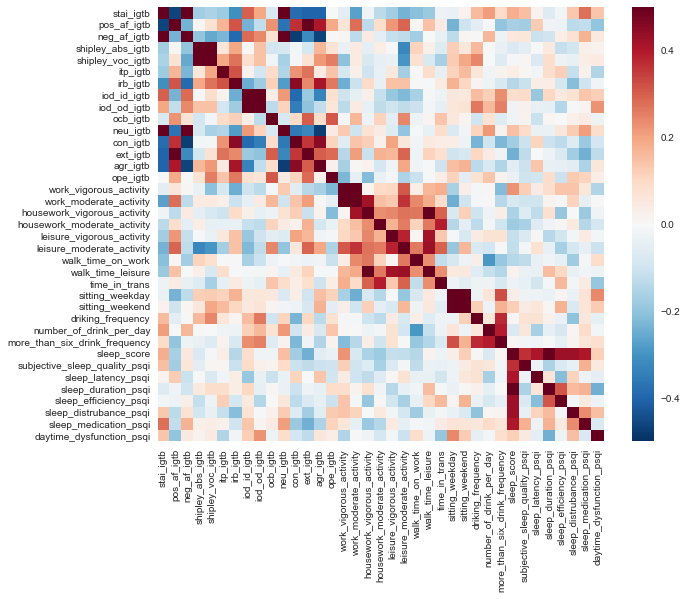

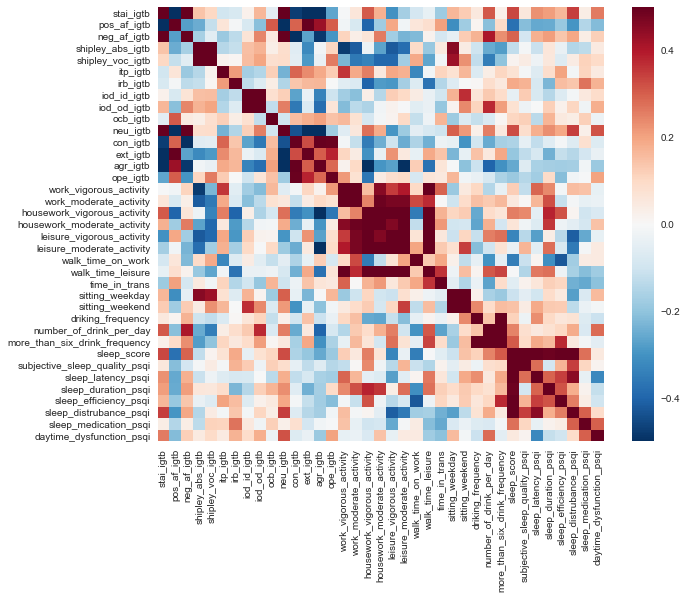

In [166]:
import seaborn as sns

corr_col = ['stai_igtb', 'pos_af_igtb', 'neg_af_igtb',
            'shipley_abs_igtb', 'shipley_voc_igtb',
            'itp_igtb', 'irb_igtb', 
            'iod_id_igtb', 'iod_od_igtb', 'ocb_igtb',
            'neu_igtb', 'con_igtb', 'ext_igtb', 
            'agr_igtb', 'ope_igtb',
            'work_vigorous_activity', 'work_moderate_activity', 
            'housework_vigorous_activity', 'housework_moderate_activity',
            'leisure_vigorous_activity', 'leisure_moderate_activity',
            'walk_time_on_work', 'walk_time_leisure', 'time_in_trans',
            'sitting_weekday', 'sitting_weekend',
            'driking_frequency', 'number_of_drink_per_day', 'more_than_six_drink_frequency',
            'sleep_score',
            'subjective_sleep_quality_psqi', 'sleep_latency_psqi', 'sleep_duration_psqi',
            'sleep_efficiency_psqi', 'sleep_distrubance_psqi', 'sleep_medication_psqi', 'daytime_dysfunction_psqi']

# shift_pre-study
day_stats   = IGTB_RAW_Score.loc[(IGTB_RAW_Score['Shift'] == 'Day shift')][corr_col]
night_stats = IGTB_RAW_Score.loc[(IGTB_RAW_Score['Shift'] == 'Night shift')][corr_col]

# day_stats   = IGTB_RAW_Score.loc[(IGTB_RAW_Score['PrimaryUnit'].str.contains('ICU'))][corr_col]
# night_stats = IGTB_RAW_Score.loc[(IGTB_RAW_Score['PrimaryUnit'].str.contains('ICU') == False)][corr_col]

# day_stats   = IGTB_RAW_Score.loc[(IGTB_RAW_Score['Sex'].str.contains('Male'))][corr_col]
# night_stats = IGTB_RAW_Score.loc[(IGTB_RAW_Score['Sex'].str.contains('Female'))][corr_col]

f, ax = plt.subplots(figsize=(10, 8))

corr = day_stats.corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmin=-0.5, vmax=0.5)
plt.show()

f, ax = plt.subplots(figsize=(10, 8))

corr = night_stats.corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, vmin=-0.5, vmax=0.5)

plt.show()


# f, ax = plt.subplots(figsize=(10, 8))

# corr = day_stats.corr(method='pearson') - night_stats.corr(method='pearson')
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

# plt.show()
